## AUTO ML CLASSIFICATION MODEL WITH RAPIDS

#### WITHOUT CANADA
#### ALL FEATURES
#### TARGET WITH INFLUENCER MODIFIED and SPLIT BY MEAN

In [42]:
# !pip install gdown
# !mkdir data
# !cd data
# !gdown 1D0goLpsXELNET-tzcn_nJutXVBaF-EYR
# !unzip csv_for_ml.zip

In [43]:
# #!conda init bash
# !conda activate rapids-22.02
# !python3 -c "import cudf, cuml; print(cudf.__version__); print(cuml.__version__)"
# !conda deactivate

In [44]:
import pandas as pd
from functools import reduce

In [45]:
business = pd.read_csv('./data/business.csv')
attributes = pd.read_csv('./data/atributtes_clean.csv', low_memory=False)
categories = pd.read_csv('./data/categories_fixed.csv')
hours = pd.read_csv('./data/hours_fixed.csv')
gps = pd.read_csv('./data/gps_clustering.csv')
checkins = pd.read_csv('./data/n_checkins.csv')
top_tips = pd.read_csv('./data/top_tips.csv')
target1 = pd.read_csv('./data/target.csv')
target2 = pd.read_csv('./data/target2.csv')
target3 = pd.read_csv('./data/target_3_influencer_modified.csv')
sentiment = pd.read_csv('./data/sentiment_ok_unique.csv')

In [46]:
data_frames = [business, attributes, categories, hours, gps, checkins, top_tips, target3]
full_data_2 = reduce(lambda left,right: pd.merge(left,right,on='business_id', how='left'), data_frames)

In [47]:
full_data_2.columns

Index(['business_id', 'name', 'postal_code', 'latitude_x', 'longitude_x',
       'stars', 'review_count_x', 'is_open', 'good_ambience', 'garage',
       'BusinessAcceptsCreditCards', 'RestaurantsPriceRange2', 'BikeParking',
       'WiFi', 'delivery', 'GoodForKids', 'OutdoorSeating',
       'RestaurantsReservations', 'HasTV', 'RestaurantsGoodForGroups',
       'Alcohol', 'ByAppointmentOnly', 'Caters', 'RestaurantsAttire',
       'NoiseLevel', 'meal_diversity', 'Restaurants', 'Food', 'Shopping',
       'Home Services', 'Beauty & Spas', 'Nightlife', 'Health & Medical',
       'Local Services', 'Bars', 'Automotive', 'total_categories', '7days',
       'weekends', 'n_open_days', 'mean_total_hours_open', 'mean_open_hour',
       'mean_close_hour', 'latitude_y', 'longitude_y', 'areas',
       'number_visits', 'number_tips', 'Unnamed: 0', 'review_count_y',
       'avg(reactions)', 'avg(stars)', 'avg(Influencer_2)', 'success_score',
       'target'],
      dtype='object')

In [48]:
to_drop = ['name', 'postal_code', 'latitude_x', 'longitude_x', 'stars',
 'review_count_x', 'is_open', 'latitude_y', 'longitude_y',  'number_visits', 
 'number_tips', 'Unnamed: 0', 'review_count_y','avg(reactions)', 'avg(stars)', 
 'avg(Influencer_2)', 'success_score',
 'total_categories', '7days', 'n_open_days', 'mean_open_hour', 'mean_close_hour'
 ]
full_data_2.drop(to_drop, inplace=True, axis=1)

In [49]:
full_data_2 = full_data_2.loc[full_data_2['areas'] != 7, :]

In [50]:
full_data_2.index = full_data_2['business_id']
full_data_2.drop('business_id', axis=1, inplace=True)

In [51]:
full_data_2.columns

Index(['good_ambience', 'garage', 'BusinessAcceptsCreditCards',
       'RestaurantsPriceRange2', 'BikeParking', 'WiFi', 'delivery',
       'GoodForKids', 'OutdoorSeating', 'RestaurantsReservations', 'HasTV',
       'RestaurantsGoodForGroups', 'Alcohol', 'ByAppointmentOnly', 'Caters',
       'RestaurantsAttire', 'NoiseLevel', 'meal_diversity', 'Restaurants',
       'Food', 'Shopping', 'Home Services', 'Beauty & Spas', 'Nightlife',
       'Health & Medical', 'Local Services', 'Bars', 'Automotive', 'weekends',
       'mean_total_hours_open', 'areas', 'target'],
      dtype='object')

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

#from functions import run_exps

import warnings
warnings.filterwarnings('ignore') 

In [53]:
# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

full_data_2['mean_total_hours_open'] = mice_imputer.fit_transform(full_data_2['mean_total_hours_open'].values.reshape(-1,1))

In [54]:
full_data_2.fillna(0, inplace=True)

In [55]:
full_data_3 = full_data_2.copy()

In [56]:
ohe = OneHotEncoder(sparse=False)
to_transform = ['areas', 'RestaurantsPriceRange2']
X = ohe.fit_transform(full_data_2[to_transform])
X = pd.DataFrame(X, columns=ohe.get_feature_names(to_transform), index=full_data_2.index)
full_data_2 = pd.concat([full_data_2, X], axis=1)
full_data_2.drop(to_transform, axis=1, inplace=True)

In [57]:
full_data_2.shape

(145875, 45)

In [58]:
full_data_2.isna().sum().sum()

0

In [59]:
#!pip install wandb
#import wandb
#wandb.init(project="henry-tf-g2-ml1")

In [60]:
!pip install tpot
import tpot

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    full_data_2.drop('target', axis=1), full_data_2['target'], test_size=0.2,
    random_state=42)

In [62]:
full_data_2.to_csv('./data/automl_gpu_7.csv', index = True)

In [68]:
pipeline_optimizer = tpot.TPOTClassifier(generations=5, #number of iterations to run the training
                                        population_size=20, #number of individuals to train
                                        cv=10, max_time_mins = 100,
                                        config_dict="TPOT cuML") #number of folds in StratifiedKFold
pipeline_optimizer.fit(X_train, y_train) #fit the pipeline optimizer - can take a long time

print(pipeline_optimizer.score(X_test, y_test)) #print scoring for the pipeline
pipeline_optimizer.export('automl_pipeline_gpu_class.py') #export the pipeline - in Python code!

0.8453813196229649


In [64]:
!pip install wandb plotly
import wandb
wandb.login()

wandb: Currently logged in as: maico (hayequipo). Use `wandb login --relogin` to force relogin


True

In [70]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFwe, f_classif

# Average CV score on the training set was: 0.8492544987146529
exported_pipeline = make_pipeline(
    SelectFwe(score_func=f_classif, alpha=0.031),
    XGBClassifier(alpha=1, learning_rate=0.5, max_depth=4, min_child_weight=14, n_estimators=100, n_jobs=1, subsample=0.8500000000000001, tree_method="gpu_hist", verbosity=0)
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

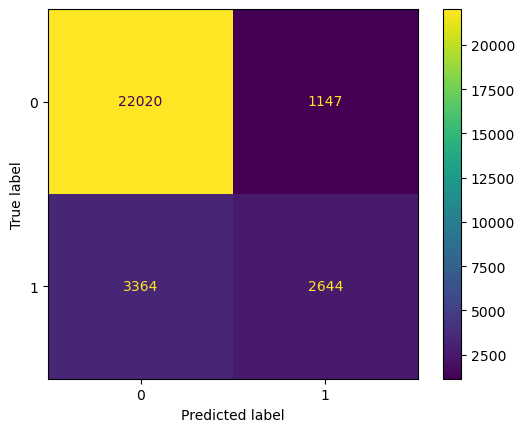

[[22020  1147]
 [ 3364  2644]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     23167
           1       0.70      0.44      0.54      6008

    accuracy                           0.85     29175
   macro avg       0.78      0.70      0.72     29175
weighted avg       0.83      0.85      0.83     29175



In [71]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test, results)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, results))
print(classification_report(y_test, results))

ValueError: tree must be Booster, XGBModel or dict instance

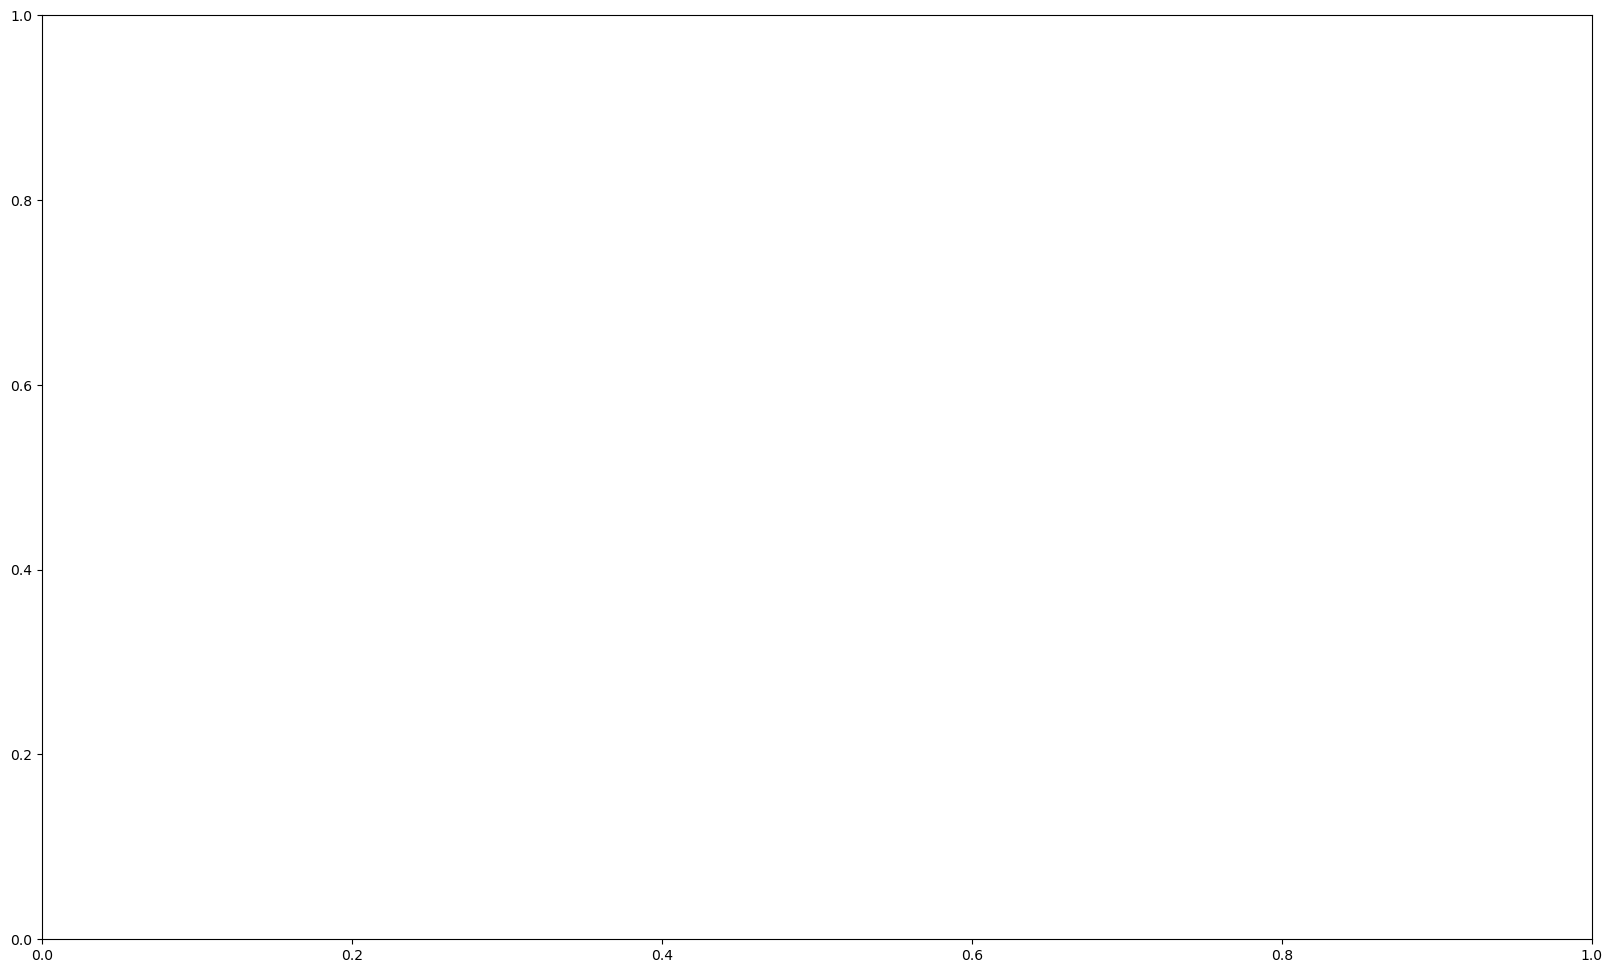

In [72]:
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore') 
# Plot the feature importances
fig, ax = plt.subplots(figsize=(20, 12))
xgb.plot_importance(exported_pipeline, ax=ax)
plt.show()

In [73]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, results)

In [75]:
accuracy

0.8453813196229649

In [74]:
# OR to log a final metric at the end of training you can also use wandb.summary
wandb.summary["accuracy"] = accuracy

Error: You must call wandb.init() before wandb.summary["accuracy"]

In [ ]:
# OR to log a final metric at the end of training you can also use wandb.summary
wandb.summary["accuracy"] = accuracy
# Visualize single plot
wandb.sklearn.plot_confusion_matrix(y_test, results)